# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from dtw import dtw
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.stattools import acf

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [3]:
mu = 0
sigma = 1
autocorrelations = {}

for N in [200, 500, 1000]:

    autocorrelation_N = np.zeros((100, N))

    for i in range(100):
        signal = mu + sigma * np.random.randn(N)
        autocorrelation_N[i] = acf(signal, nlags=N, fft=True)

    autocorrelations[N] = [autocorrelation_N.mean(axis=0), autocorrelation_N.std(axis=0)] 

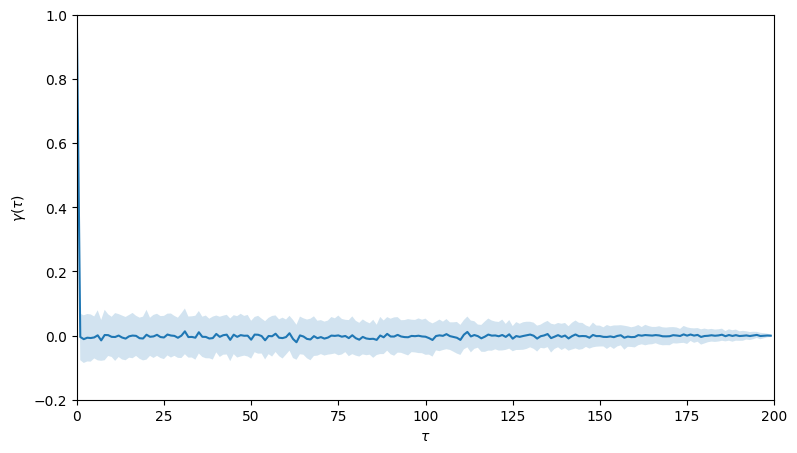

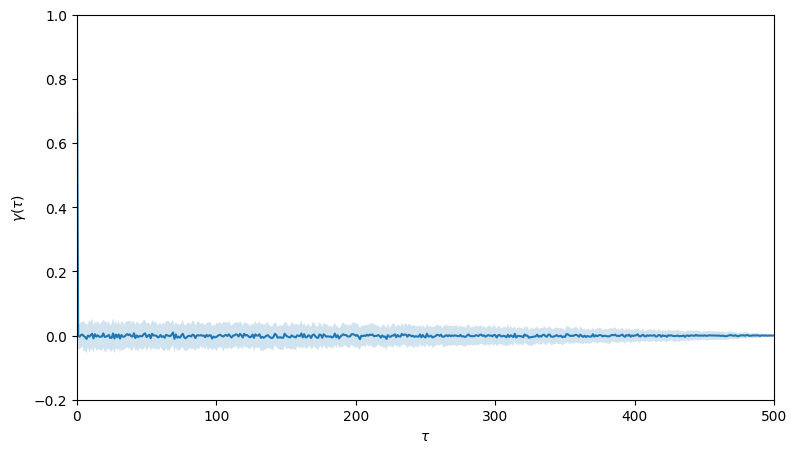

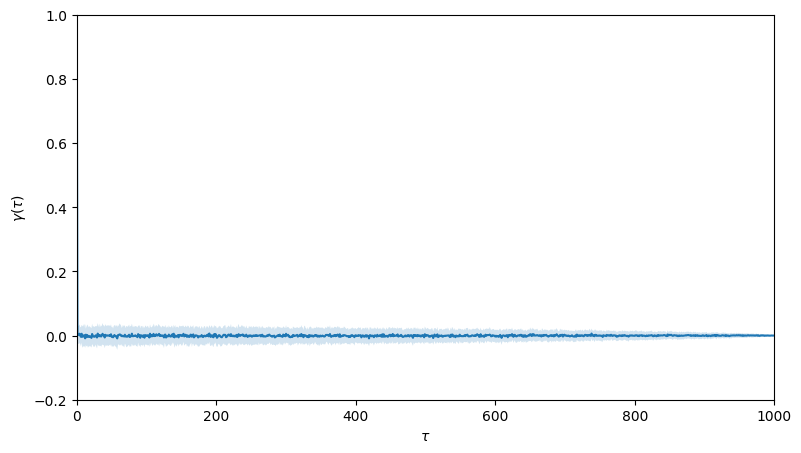

In [4]:
for N, (avg, std) in autocorrelations.items():
    plt.figure(figsize=(9, 5))
    plt.plot(range(N), avg)
    plt.fill_between(range(N), avg-std, avg+std, alpha=0.2)
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$\gamma$($\tau$)')
    plt.xlim(0,N)
    plt.ylim(-.2,1)


In [5]:
def periodogram(X, fs = 1):
    N = len(X)
    freqs = np.linspace(0, fs/2, N//2)
    pxx = np.array([(1/N) * np.abs(np.sum([X[n] * np.exp(-2j * np.pi * fk * n / fs) for n in range(N)]))**2 for fk in freqs])
    return freqs, pxx

In [6]:
mu = 0
sigma = 1
periodograms = {}

for N in [200, 500, 1000]:

    freqs = None
    periodogram_N = np.zeros((100, N//2))

    for i in range(100):
        signal = mu + sigma * np.random.randn(N)
        freqs, pxx = periodogram(signal)
        periodogram_N[i] = pxx

    periodograms[N] = [freqs, periodogram_N.mean(axis=0), periodogram_N.std(axis=0)] 

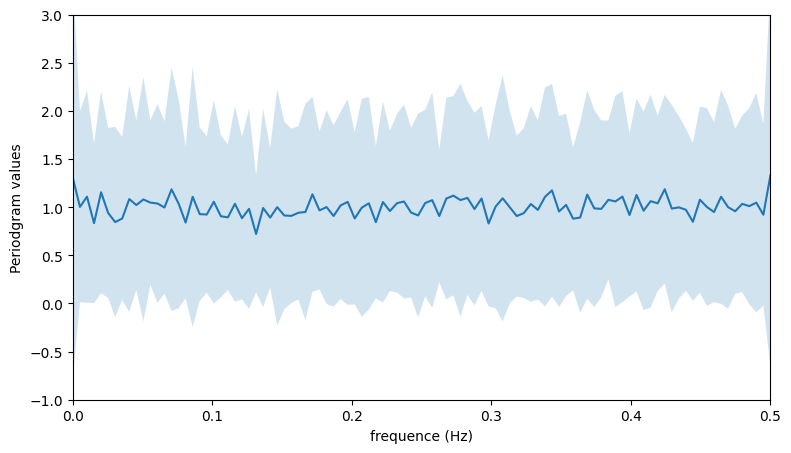

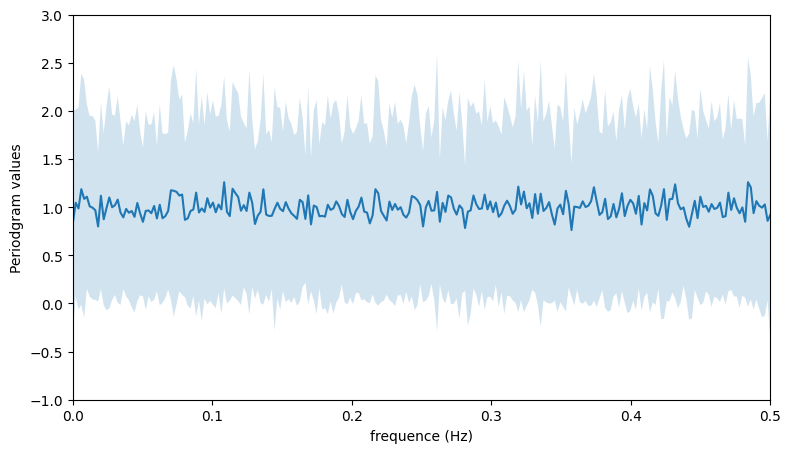

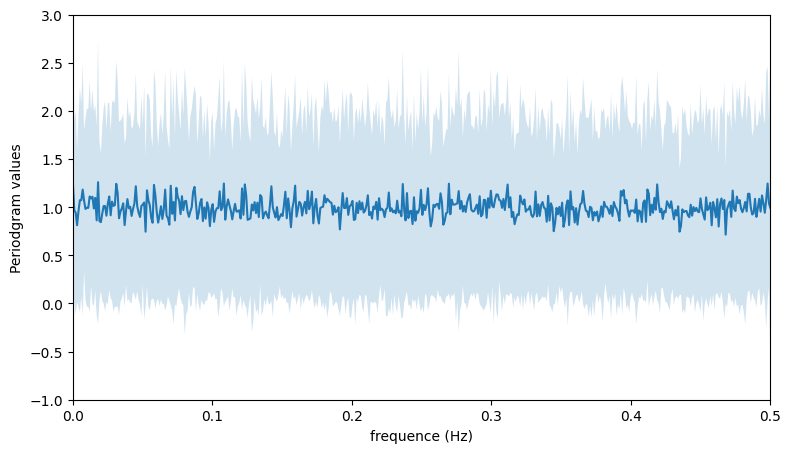

In [7]:
for N, (freqs, avg, std) in periodograms.items():
    plt.figure(figsize=(9, 5))
    plt.plot(freqs, avg)
    plt.fill_between(freqs, avg-std, avg+std, alpha=0.2)
    plt.xlabel("frequence (Hz)")
    plt.ylabel("Periodgram values")
    plt.xlim(0, max(freqs))
    plt.ylim(-1, 3)

## Question 9

In [8]:
mu = 0
sigma = 1
periodograms = {}
K = 5

for N in [200, 500, 1000]:

    freqs = None
    periodogram_N = np.zeros((100, N//(2*K)))

    for i in range(100):

        signal = mu + sigma * np.random.randn(N)
        sub_periodgram = np.zeros((K, N//(2*K)))

        for j, k in enumerate(range(0, N, N//K)):
            sub_signal = signal[k : k + N//K]
            freqs, pxx = periodogram(sub_signal)
            sub_periodgram[j] = pxx

        periodogram_N[i] = sub_periodgram.mean(0)

    periodograms[N] = [freqs, periodogram_N.mean(axis=0), periodogram_N.std(axis=0)] 

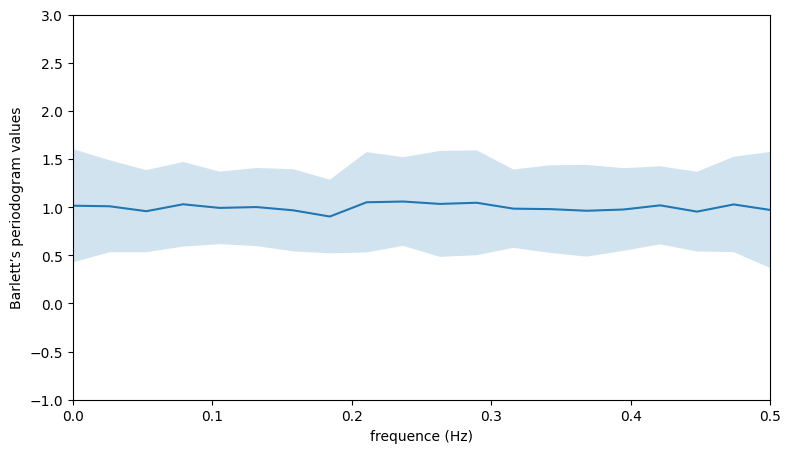

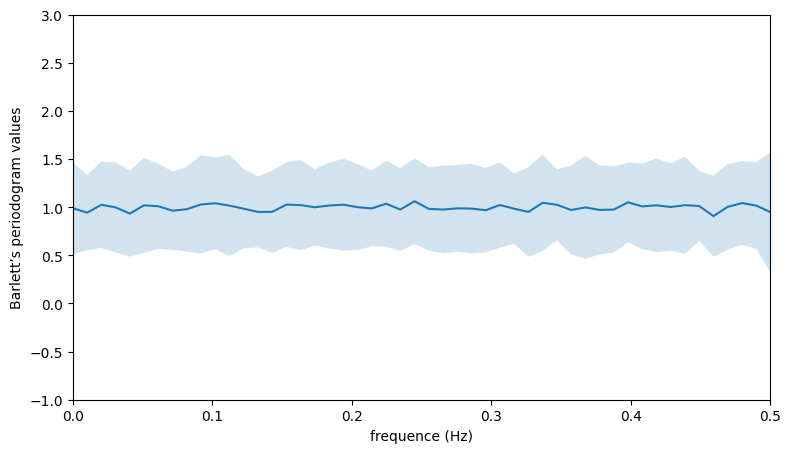

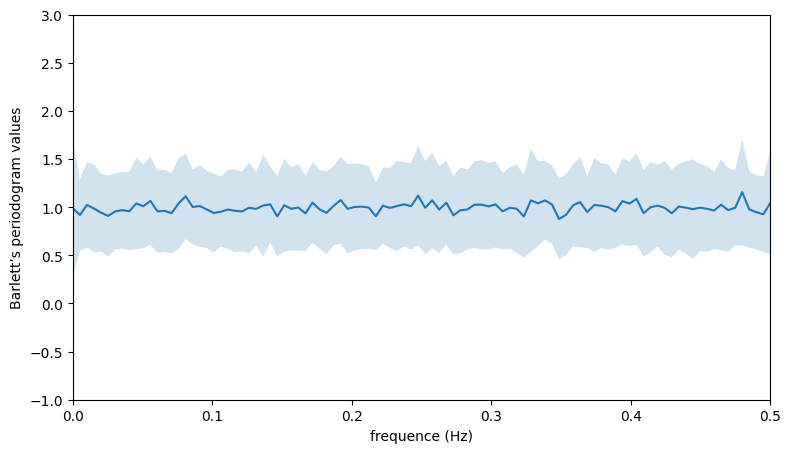

In [9]:
for N, (freqs, avg, std) in periodograms.items():
    plt.figure(figsize=(9, 5))
    plt.plot(freqs, avg)
    plt.fill_between(freqs, avg-std, avg+std, alpha=0.2)
    plt.xlabel("frequence (Hz)")
    plt.ylabel("Barlett’s periodogram values")
    plt.xlim(0, max(freqs))
    plt.ylim(-1, 3)

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [10]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

In [11]:
def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float:
    return dtw(signal_1, signal_2, keep_internals=True).distance

In [12]:
X_concat = X_train + X_test
y_concat = y_train + y_test

indices = list(range(len(X_concat)))
random.shuffle(indices)

X_concat = [X_concat[i] for i in indices]
y_concat = [y_concat[i] for i in indices]

X_train = X_concat[:168]
X_test = X_concat[168:]

y_train = y_concat[:168]
y_test = y_concat[168:]

In [13]:
MAX_SIGNAL_LENGTH = max(map(len,X_concat))
print(MAX_SIGNAL_LENGTH)

147


In [14]:
def to_signal_matrix(X):
    return np.array(
        [list(signal) + [-1] * (MAX_SIGNAL_LENGTH - len(signal)) for signal in X]
    )

In [15]:
X_matrix_train = to_signal_matrix(X_train)
X_matrix_test = to_signal_matrix(X_test)
X_matrix_train.shape, X_matrix_test.shape

((168, 147), (88, 147))

## Question 10

In [16]:
knn = KNeighborsClassifier(metric=get_dtw_distance, weights='distance')
cv = GridSearchCV(knn, {"n_neighbors" :range(3, 12, 2)}, cv=5, scoring=make_scorer(f1_score))
cv.fit(X_matrix_train, y_train)
print(f"Optimal number of neighbors : {cv.best_params_['n_neighbors']}")
print(f"Average f1-score : {cv.best_score_}")

Optimal number of neighbors : 3
Average f1-score : 0.8691599816330389


In [17]:
knn = KNeighborsClassifier(metric=get_dtw_distance, weights='distance', n_neighbors=cv.best_params_['n_neighbors'])
knn.fit(X_matrix_train, y_train)

y_pred = knn.predict(X_matrix_train)
print(f"[Train] F1-Score : {f1_score(y_train, y_pred)}")

y_pred = knn.predict(X_matrix_test)
print(f"[Test] F1-Score : {f1_score(y_test, y_pred)}")

[Train] F1-Score : 1.0
[Test] F1-Score : 0.8431372549019607


## Question 11

In [18]:
mask = np.where(y_pred != y_test)[0]
bad_classif = np.array(y_test)[mask]

healthy_idx = np.where(bad_classif==0)[0][0]
bad_healthy = X_test[mask[healthy_idx]]
bad_healthy = bad_healthy[np.where(bad_healthy!=-1)]

no_healthy_idx = np.where(bad_classif==1)[0][0]
bad_no_healthy = X_test[mask[no_healthy_idx]]
bad_no_healthy = bad_no_healthy[np.where(bad_no_healthy!=-1)]

(0.0, 95.0)

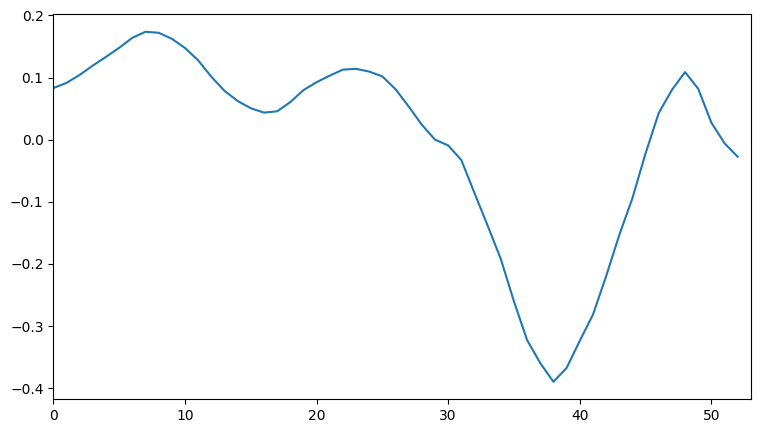

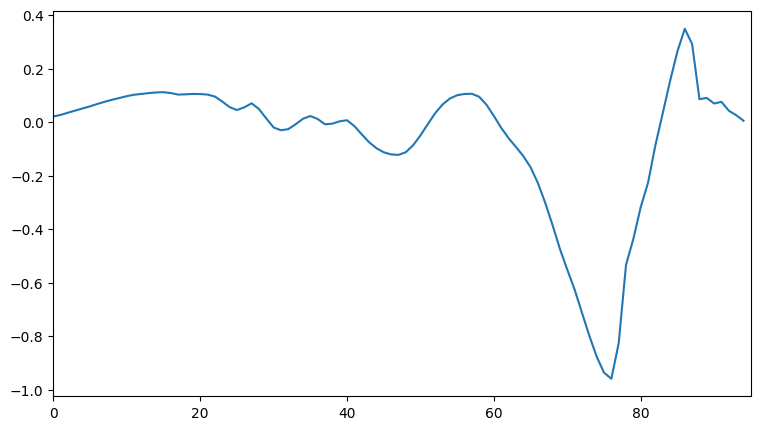

In [19]:
plt.figure(figsize=(9,5))
plt.plot(bad_healthy)
plt.xlim(0, bad_healthy.size)

plt.figure(figsize=(9,5))
plt.plot(bad_no_healthy)
plt.xlim(0, bad_no_healthy.size)
